In [1]:
import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.optim.lr_scheduler as scheduler
from torch.utils.data import random_split,DataLoader

import torchvision
from torchvision.datasets import CIFAR10,CIFAR100
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Normalize

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device(0))

cuda
0
1
GeForce RTX 3090


In [3]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

True
학습을 진행하는 기기: cuda:0


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
ds10=CIFAR10(root="./data",download=True,train=True,transform=transform)
ts10=CIFAR10(root="./data",download=True,train=False,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
tr10,vs10,_=random_split(ds10,[1000,1000,48000],torch.manual_seed(1))

In [7]:
#tr10

class_count={}
for i in tr10:
    if i[1] not in class_count:
        class_count[i[1]]=0
    class_count[i[1]]+=1
print(class_count)

{0: 98, 1: 105, 6: 107, 3: 94, 4: 93, 8: 91, 7: 98, 2: 107, 5: 98, 9: 109}


In [8]:
#vs10

class_count={}
for i in vs10:
    if i[1] not in class_count:
        class_count[i[1]]=0
    class_count[i[1]]+=1
print(class_count)

{5: 105, 3: 106, 1: 100, 2: 101, 0: 85, 4: 96, 7: 99, 6: 101, 8: 111, 9: 96}


In [9]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.layer3 = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10),
            )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        #out = out.view(out.size(0),-1) #Flatten feature mapes to one-dimension vector
        out = out.view(-1,16*5*5)
        out = self.layer3(out)
        return out


In [10]:
myCnn=MyCNN().to(device)
training_epochs=20
batch_size=4
obj=nn.CrossEntropyLoss().to(device)
opt=SGD(myCnn.parameters(),lr=0.001, momentum=0.9)

In [11]:
tr10_loader=DataLoader(dataset=tr10,
                      batch_size=batch_size,
                      shuffle=True,
                      drop_last=True)

vs10_loader=DataLoader(dataset=vs10,
                      batch_size=batch_size,
                      shuffle=False)

In [12]:
start=time.time()

training_loss_history=[]
validation_loss_history=[]

for epoch in range(training_epochs):
    training_loss=0.0
    validation_loss=0.0
    for X,y in tr10_loader:
        X=X.to(device)
        y=y.to(device)
        
        opt.zero_grad()
        output=myCnn(X) 
        cost=obj(output,y)
        cost.backward()
        opt.step()
        
        training_loss+=cost.item()
        
    with torch.no_grad():
        for X,y in vs10_loader:
            X=X.to(device)
            y=y.to(device)
            
            output=myCnn(X)
            cost=obj(output,y)
            
            validation_loss+=cost.item()
            
#    if epoch==39:        
#        sch.step()        
    training_loss_history.append(training_loss/(1000/batch_size))
    validation_loss_history.append(validation_loss/(1000/batch_size))
    print("[ Epoch: ",epoch+1," loss :",training_loss/(1000/batch_size)," validation :",validation_loss/(1000/batch_size),"]")
    
print("Time :",time.time()-start)

[ Epoch:  1  loss : 2.302429288864136  validation : 2.2991176328659058 ]
[ Epoch:  2  loss : 2.2935703344345093  validation : 2.2887866916656496 ]
[ Epoch:  3  loss : 2.2735856885910035  validation : 2.2530035772323607 ]
[ Epoch:  4  loss : 2.2213294343948364  validation : 2.1830824842453005 ]
[ Epoch:  5  loss : 2.165205443382263  validation : 2.128535688877106 ]
[ Epoch:  6  loss : 2.1196780338287353  validation : 2.0705737833976747 ]
[ Epoch:  7  loss : 2.053048376560211  validation : 2.000172462940216 ]
[ Epoch:  8  loss : 1.9768080186843873  validation : 1.9782425179481506 ]
[ Epoch:  9  loss : 1.904852038860321  validation : 1.9044241106510162 ]
[ Epoch:  10  loss : 1.8428871655464172  validation : 1.996491464138031 ]
[ Epoch:  11  loss : 1.793424414873123  validation : 1.8196672415733337 ]
[ Epoch:  12  loss : 1.7432155921459198  validation : 1.853378493309021 ]
[ Epoch:  13  loss : 1.6904192838668823  validation : 1.8498732948303223 ]
[ Epoch:  14  loss : 1.6289263479709626  va

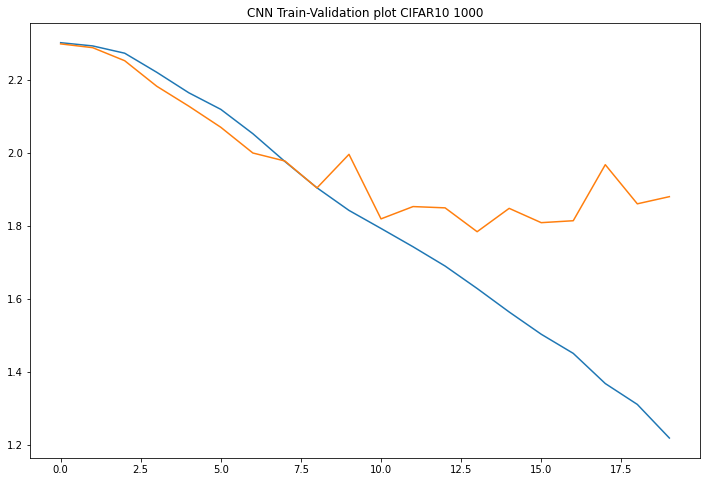

In [13]:
plt.figure(figsize=(12,8))
plt.plot(training_loss_history)
plt.plot(validation_loss_history)
plt.title("CNN Train-Validation plot CIFAR10 1000")
plt.savefig("CNN Train-Validation plot CIFAR10 1000.png")

In [14]:
myCnn=MyCNN().to(device)
training_epochs=11
batch_size=4
obj=nn.CrossEntropyLoss().to(device)
opt=SGD(myCnn.parameters(),lr=0.001, momentum=0.9)

In [15]:
start=time.time()

for epoch in range(training_epochs):
    training_loss=0.0
    validation_loss=0.0
    for X,y in tr10_loader:
        X=X.to(device)
        y=y.to(device)
        
        opt.zero_grad()
        output=myCnn(X) 
        cost=obj(output,y)
        cost.backward()
        opt.step()
        
print("Time :",time.time()-start)

Time : 8.180013179779053


In [16]:
ts10,_=random_split(ts10,[1000,9000],torch.manual_seed(1))

In [17]:
#ts10

class_count={}
for i in ts10:
    if i[1] not in class_count:
        class_count[i[1]]=0
    class_count[i[1]]+=1
print(class_count)

{5: 107, 0: 105, 6: 96, 1: 122, 9: 88, 8: 91, 4: 103, 3: 112, 7: 95, 2: 81}


In [18]:
ts10_loader=DataLoader(dataset=ts10,
                      batch_size=batch_size,
                      shuffle=False)

In [19]:
start=time.time()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in ts10_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = myCnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy :',(100 * correct / total))
print("Time :",time.time()-start)

Accuracy : 29.1
Time : 0.4030911922454834


In [20]:
ds100=CIFAR100(root="./data",download=True,train=True,transform=transform)
ts100=CIFAR100(root="./data",download=True,train=False,transform=transform)
tr100,vs100,_=random_split(ds100,[1000,1000,48000],torch.manual_seed(1))

Files already downloaded and verified
Files already downloaded and verified


In [21]:
tr100_loader=DataLoader(dataset=tr100,
                      batch_size=batch_size,
                      shuffle=True,
                      drop_last=True)

vs100_loader=DataLoader(dataset=vs100,
                      batch_size=batch_size,
                      shuffle=False)

In [22]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.layer3 = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,100),
            )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        #out = out.view(out.size(0),-1) #Flatten feature mapes to one-dimension vector
        out = out.view(-1,16*5*5)
        out = self.layer3(out)
        return out


In [23]:
myCnn=MyCNN().to(device)
training_epochs=20
batch_size=4
obj=nn.CrossEntropyLoss().to(device)
opt=SGD(myCnn.parameters(),lr=0.001, momentum=0.9)

In [24]:
start=time.time()

training_loss_history_=[]
validation_loss_history_=[]

for epoch in range(training_epochs):
    training_loss=0.0
    validation_loss=0.0
    for X,y in tr100_loader:
        X=X.to(device)
        y=y.to(device)
        
        opt.zero_grad()
        output=myCnn(X) 
        cost=obj(output,y)
        cost.backward()
        opt.step()
        
        training_loss+=cost.item()
        
    with torch.no_grad():
        for X,y in vs100_loader:
            X=X.to(device)
            y=y.to(device)
            
            output=myCnn(X)
            cost=obj(output,y)
            
            validation_loss+=cost.item()
            
#    if epoch==39:        
#        sch.step()        
    training_loss_history_.append(training_loss/(1000/batch_size))
    validation_loss_history_.append(validation_loss/(1000/batch_size))
    print("[ Epoch: ",epoch+1," loss :",training_loss/(1000/batch_size)," validation :",validation_loss/(1000/batch_size),"]")
    
print("Time :",time.time()-start)

[ Epoch:  1  loss : 4.610046918869019  validation : 4.604905164718628 ]
[ Epoch:  2  loss : 4.604483694076538  validation : 4.603633518218994 ]
[ Epoch:  3  loss : 4.5991880912780765  validation : 4.6025621070861815 ]
[ Epoch:  4  loss : 4.593063772201538  validation : 4.600841171264649 ]
[ Epoch:  5  loss : 4.58501051902771  validation : 4.598505477905274 ]
[ Epoch:  6  loss : 4.569369129180908  validation : 4.600038854598999 ]
[ Epoch:  7  loss : 4.554069169998169  validation : 4.589003805160522 ]
[ Epoch:  8  loss : 4.530171850204468  validation : 4.583171243667603 ]
[ Epoch:  9  loss : 4.507263093948365  validation : 4.5651603622436525 ]
[ Epoch:  10  loss : 4.470342861175537  validation : 4.5437596282958985 ]
[ Epoch:  11  loss : 4.40562527179718  validation : 4.498443382263184 ]
[ Epoch:  12  loss : 4.322143246650696  validation : 4.461799247741699 ]
[ Epoch:  13  loss : 4.224179040908814  validation : 4.46755105304718 ]
[ Epoch:  14  loss : 4.155912905693055  validation : 4.4284

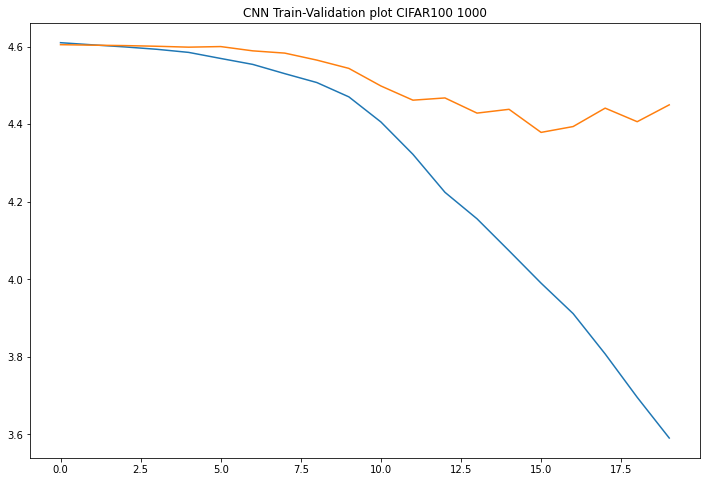

In [25]:
plt.figure(figsize=(12,8))
plt.plot(training_loss_history_)
plt.plot(validation_loss_history_)
plt.title("CNN Train-Validation plot CIFAR100 1000")
plt.savefig("CNN Train-Validation plot CIFAR100 1000.png")

In [26]:
myCnn=MyCNN().to(device)
training_epochs=12
batch_size=4
obj=nn.CrossEntropyLoss().to(device)
opt=SGD(myCnn.parameters(),lr=0.001, momentum=0.9)

In [27]:
start=time.time()

for epoch in range(training_epochs):
    training_loss=0.0
    validation_loss=0.0
    for X,y in tr100_loader:
        X=X.to(device)
        y=y.to(device)
        
        opt.zero_grad()
        output=myCnn(X) 
        cost=obj(output,y)
        cost.backward()
        opt.step()
        
print("Time :",time.time()-start)

Time : 8.924444913864136


In [28]:
ts100,_=random_split(ts100,[1000,9000],torch.manual_seed(1))

In [29]:
ts100_loader=DataLoader(dataset=ts100,
                      batch_size=batch_size,
                      shuffle=False)

In [30]:
start=time.time()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in ts100_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = myCnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy :',(100 * correct / total))
print("Time :",time.time()-start)

Accuracy : 3.1
Time : 0.4100940227508545
